# A table detection project.

This project extract values contained in a table of png files and generate a data frame.

**The algorithm consists of three parts:**

### 1. Preprocessing 

The table that contains the data we want to extract is found in a png document along with other tables and graphics. This first step consisted of cutting that table and generating a new png file with it. Then I have improved the image quality.

### 2. Cell recognition 

Delimiting the columns and rows, I have alocated each cell

### 3. Text extraction  

The extraction of each allocated cell has been performed by using Optical Character Recognition (OCR) with *pytesseract*.


In [ ]:
# All libreries I am going to use

# Needed some cleaning!!

import cv2 as cv
from pytesseract import image_to_string
from PIL import Image
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from matplotlib.pyplot import figure


import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import pytesseract
from PIL import Image

## 1. Preprocessing

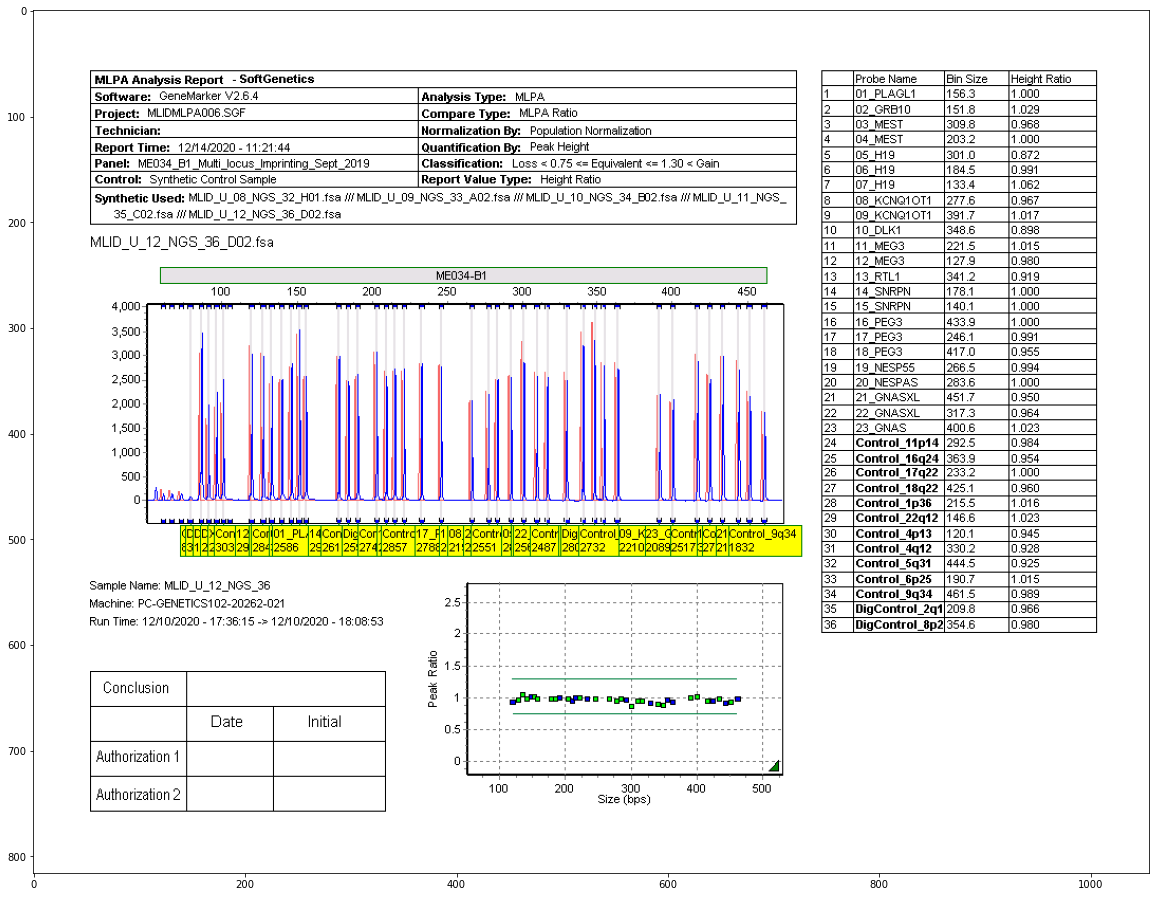

In [92]:
# First, Let´s display the image that has been given to me.
im = io.imread("/Users/monkiky/Desktop/Reading images with Python/MLPA_Pg11_MLID_U_12_NGS_36_D02_Dye_Blue.png")
plt.rcParams["figure.figsize"] = (20,20)

plt.imshow(im)
plt.show()

We want to read the table on the right side.

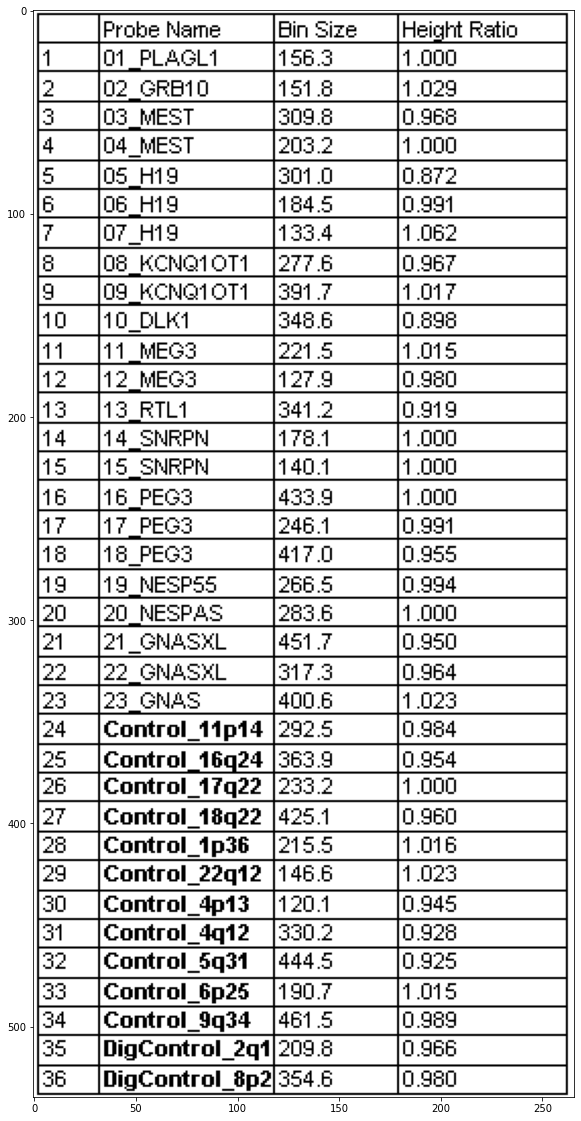

In [93]:
# Let´s select and display the table we want to read
# Manual cropped
cropped = im[55:590, 744:1010]
plt.imshow(cropped)

# Let´s make the image a little bit bigger
plt.rcParams["figure.figsize"] = (20,20)

# To save this table in a new png
plt.savefig('/Users/monkiky/Desktop/Reading images with Python/table2read.png')

# This is finally the image in which I am going to extract the data 
plt.show()

OK. Now, we have the image we wish

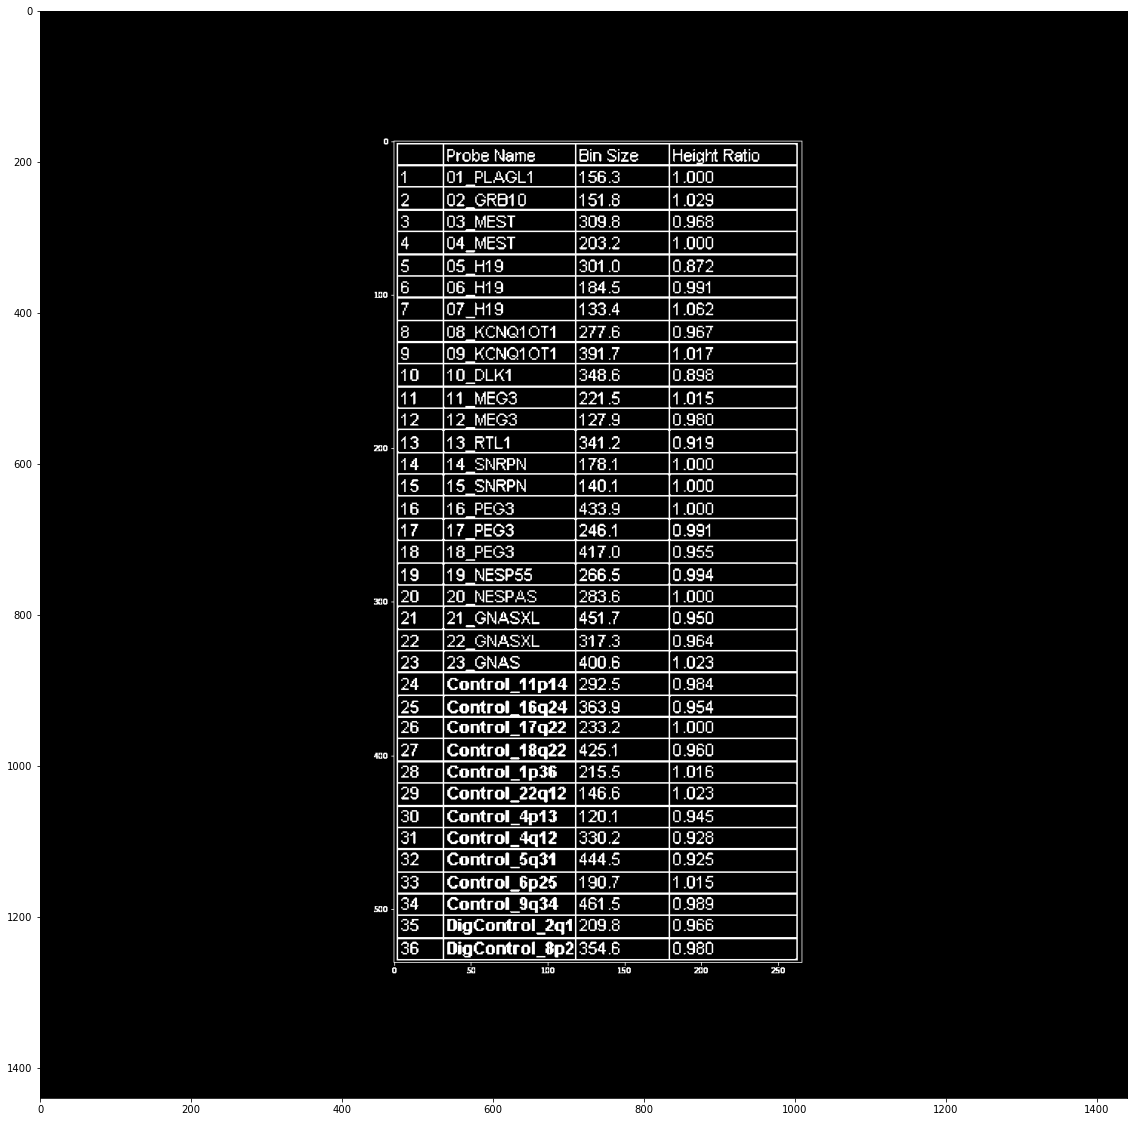

In [98]:
# Read the file we have just cropped
file=r'/Users/monkiky/Desktop/Reading images with Python/table2read.png'
img = cv2.imread(file,0)
img.shape

# To increase accuracy, it seems that is good idea to thresholding to binary image
# to then invert the image later.

#thresholding the image to a binary image
thresh,img_bin = cv2.threshold(img,128,255,cv2.THRESH_BINARY | cv2.THRESH_OTSU)
#inverting the image 
img_bin = 255-img_bin

# In case we would want to save this outoput
cv2.imwrite('/Users/monkiky/Desktop/Reading images with Python/cv_inverted.png',img_bin)
#Plotting the image to see the output
plotting = plt.imshow(img_bin,cmap='gray')
plt.show()

## 2. Cell recognition

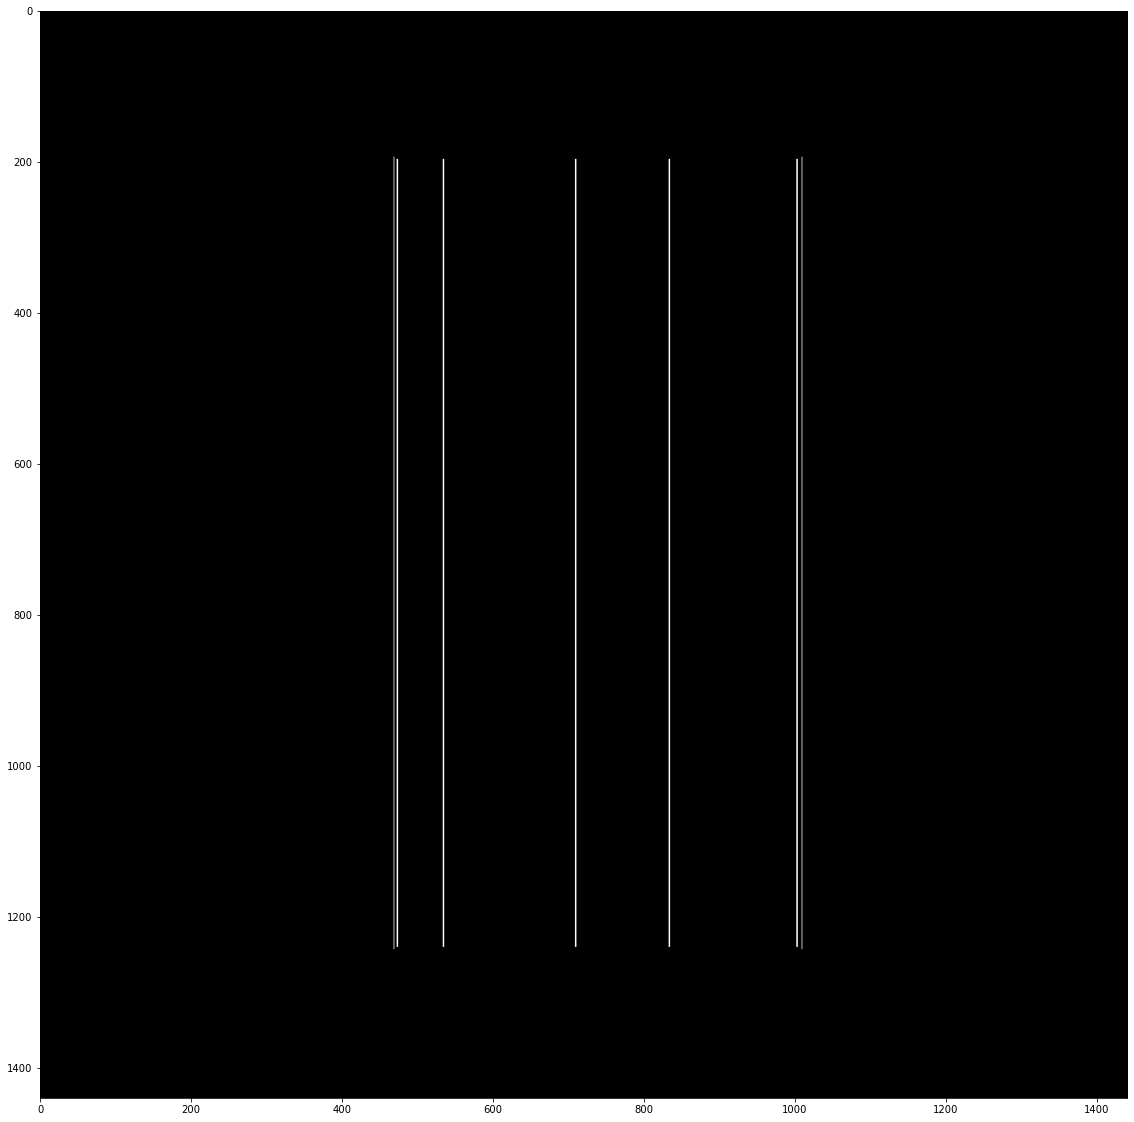

In [95]:
"""
We need to define a kernel to detect rectangular boxes, to finally identify the tabular structure. 
To do this, I first need to save horizontal and vertical lines in 2 jpg files that will be used later.
I also display this images because they are good indicator of quality during the process.
If lines are not display, tubular structure won´t be properly identify.
"""

# Width of kernel as 100th of total width
kernel_len = np.array(img).shape[1]//100
# Defining a vertical kernel 
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
# Defining a horizontal kernel 
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
# A kernel of 2x2
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))

# Now, we can save this kernel to identify the vertical lines and save them
image_1 = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_1, ver_kernel, iterations=3)
cv2.imwrite("/Users/monkiky/Desktop/Reading images with Python/vertical.jpg",vertical_lines)
#Plot the image with the vertical lines
plotting = plt.imshow(image_1,cmap='gray')
plt.show()



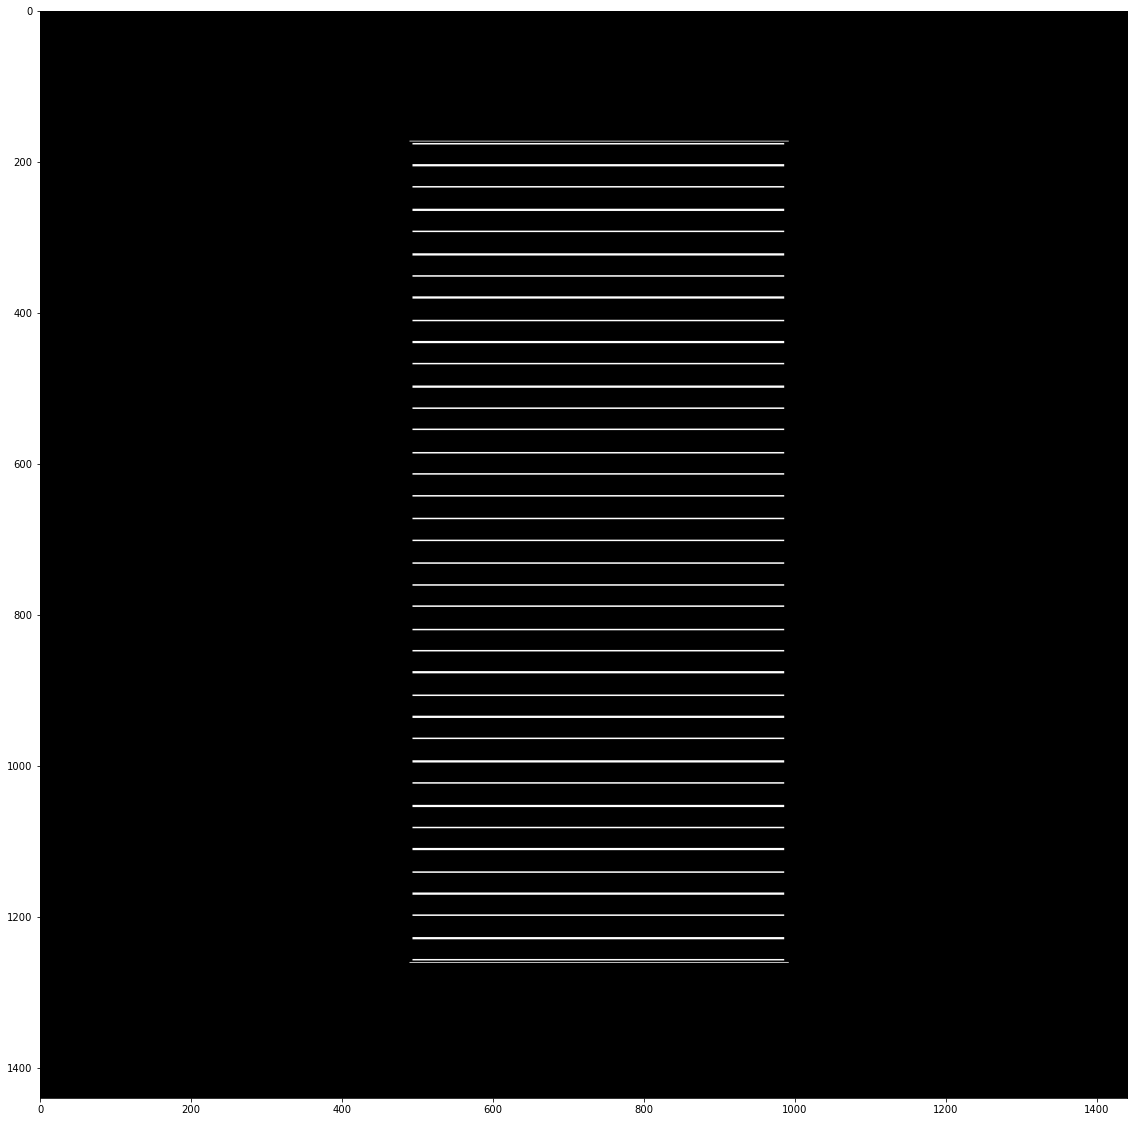

In [96]:
# Same with the horizontal ones.
image_2 = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_2, hor_kernel, iterations=3)
cv2.imwrite("/Users/monkiky/Desktop/Reading images with Python/horizontal.jpg",horizontal_lines)
#Plot the image with the horizaontal lines
plotting = plt.imshow(image_2,cmap='gray')
plt.show()


# This also works if there are lines with different length

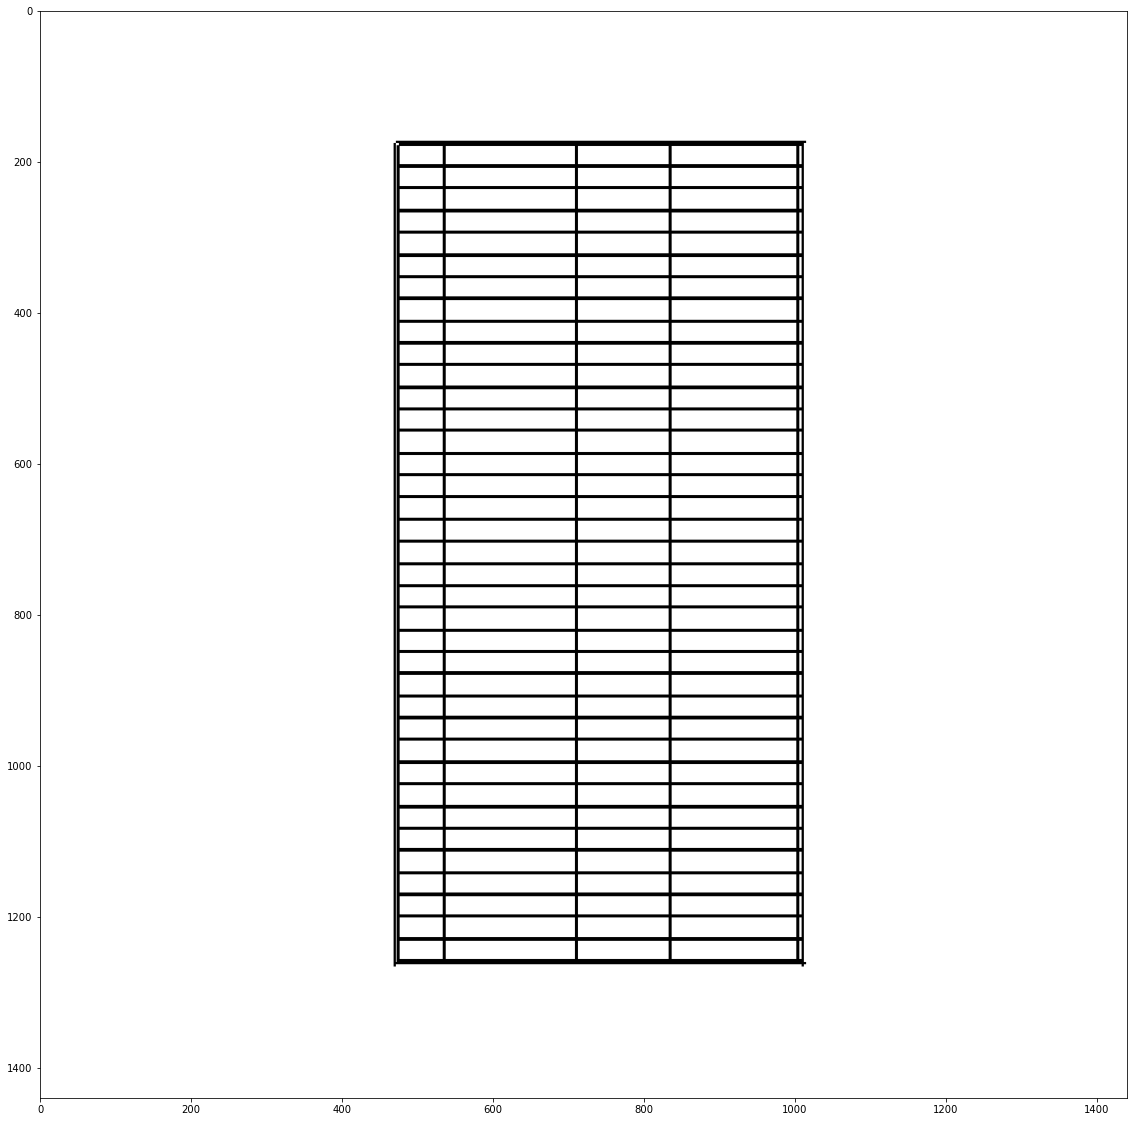

In [102]:
# Now, we just need to combine both jpg to build the table
img_vh = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
#Eroding and thesholding the image
img_vh = cv2.erode(~img_vh, kernel, iterations=2)
thresh, img_vh = cv2.threshold(img_vh,128,255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
cv2.imwrite("/Users/monkiky/Desktop/Reading images with Python/img_vhe.jpg", img_vh)
bitxor = cv2.bitwise_xor(img,img_vh)
bitnot = cv2.bitwise_not(bitxor)
#Plotting the generated image
#plotting = plt.imshow(bitnot,cmap='gray')
plotting = plt.imshow(img_vh, cmap='gray')
plt.show()

Pretty tabular structure

In [104]:
"""
Now, I need to identify cells. CV2 has a funtion that does exactly that, 
findContours function detects objects in an image.

To identify the relationship between boxes, we can used Contour Retrieval Modes, specifically 
the flag RETR_TREE which retrieves all the contours and creates a full family hierarchy list.

cv.CHAIN_APPROX_SIMPLE compresses horizontal, vertical, and diagonal segments and leaves only their end points. 
For example, an up-right rectangular contour is encoded with 4 points.

"""
# Detect contours for following box detection
contours, hierarchy = cv2.findContours(img_vh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Now, with this we can identify box by box from left to right and from top to bottom

def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0
    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

In [106]:

# Sort all the boxes by top to bottom.
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

#Get mean of heights
mean = np.mean(heights)

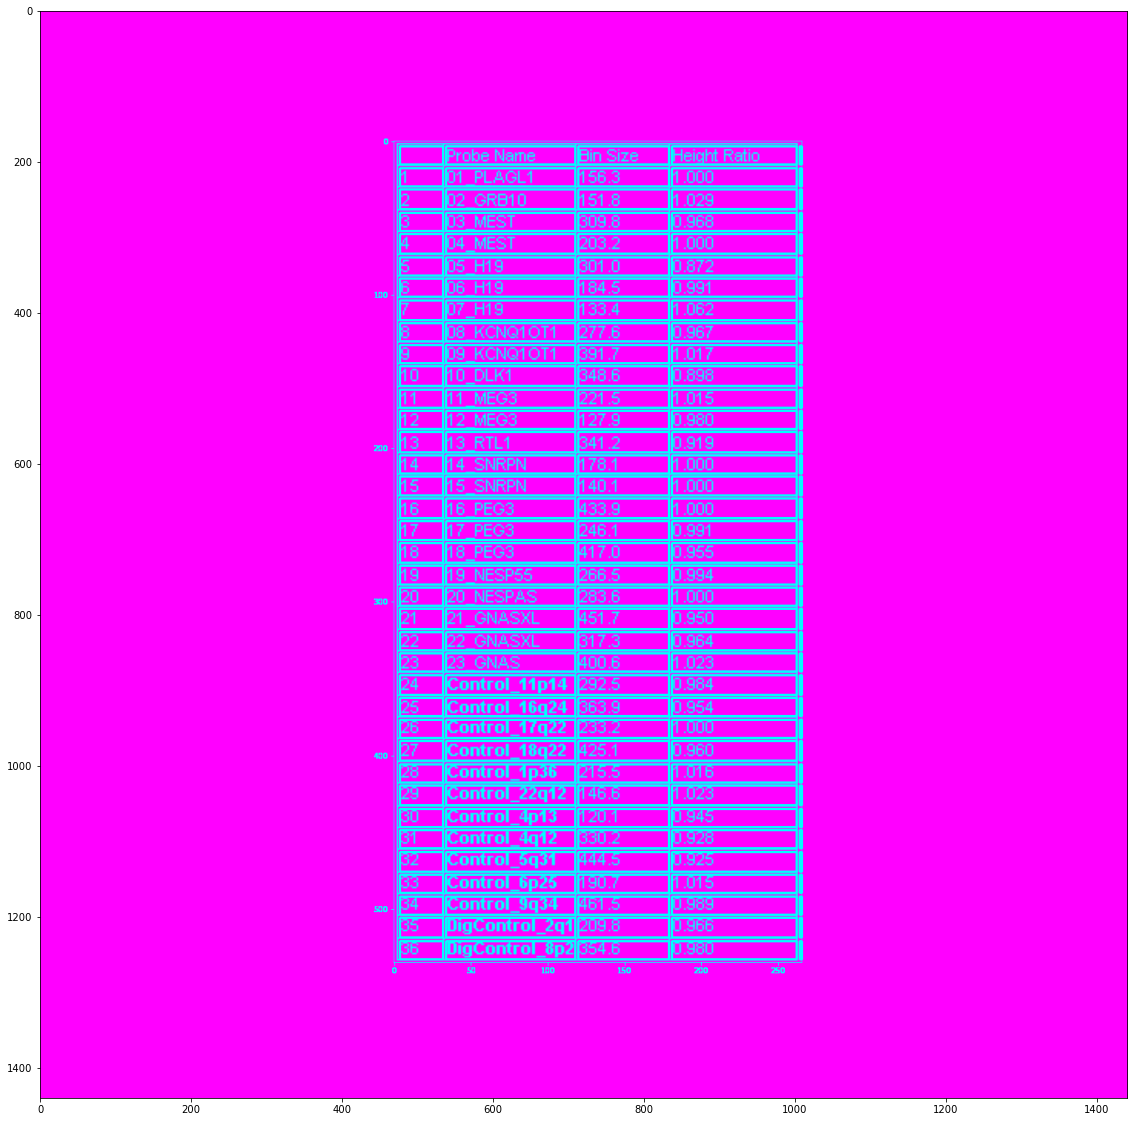

In [112]:
# Sort all the boxes by top to bottom.
contours, boundingBoxes = sort_contours(contours, method="top-to-bottom")

#Creating a list of heights for all detected boxes
heights = [boundingBoxes[i][3] for i in range(len(boundingBoxes))]

#Get mean of heights
mean = np.mean(heights)

#Create list box to store all boxes in  
box = []
# Get position (x,y), width and height for every box and show the box on image
for c in contours:
    x, y, w, h = cv2.boundingRect(c)
    if (w<1000 and h<500):
        image = cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
        box.append([x,y,w,h])
        
plotting = plt.imshow(image,cmap='cool')
plt.show()

In [115]:
#Creating two lists to define row and column in which cell is located
row=[]
column=[]
j=0

#Sorting the boxes to their respective row and column
for i in range(len(box)):    
        
    if(i==0):
        column.append(box[i])
        previous=box[i]    
    
    else:
        if(box[i][1]<=previous[1]+mean/2):
            column.append(box[i])
            previous=box[i]            
            
            if(i==len(box)-1):
                row.append(column)        
            
        else:
            row.append(column)
            column=[]
            previous = box[i]
            column.append(box[i])
            
print(column)
print(row)

[[[1005, 180, 3, 24], [836, 180, 165, 24], [712, 180, 120, 24], [537, 180, 171, 24], [476, 180, 57, 24]], [[1005, 209, 3, 24], [836, 209, 165, 24], [712, 209, 120, 24], [537, 209, 171, 24], [476, 209, 57, 24]], [[1005, 237, 3, 26], [836, 237, 165, 26], [712, 237, 120, 26], [537, 237, 171, 26], [476, 237, 57, 26]], [[1005, 268, 3, 24], [836, 268, 165, 24], [712, 268, 120, 24], [537, 268, 171, 24], [476, 268, 57, 24]], [[1005, 296, 3, 26], [836, 296, 165, 26], [712, 296, 120, 26], [537, 296, 171, 26], [476, 296, 57, 26]], [[1005, 327, 3, 24], [836, 327, 165, 24], [712, 327, 120, 24], [537, 327, 171, 24], [476, 327, 57, 24]], [[1005, 355, 3, 24], [836, 355, 165, 24], [712, 355, 120, 24], [537, 355, 171, 24], [476, 355, 57, 24]], [[1005, 384, 3, 26], [836, 384, 165, 26], [712, 384, 120, 26], [537, 384, 171, 26], [476, 384, 57, 26]], [[1005, 414, 3, 24], [836, 414, 165, 24], [712, 414, 120, 24], [537, 414, 171, 24], [476, 414, 57, 24]], [[1005, 443, 3, 24], [836, 443, 165, 24], [712, 443, 1

In [116]:
#calculating maximum number of cells
countcol = 0
for i in range(len(row)):
    countcol = len(row[i])
    if countcol > countcol:
        countcol = countcol

#Retrieving the center of each column
center = [int(row[i][j][0]+row[i][j][2]/2) for j in range(len(row[i])) if row[0]]

center=np.array(center)
center.sort()
print(center)
#Regarding the distance to the columns center, the boxes are arranged in respective order

finalboxes = []
for i in range(len(row)):
    lis=[]
    for k in range(countcol):
        lis.append([])
    for j in range(len(row[i])):
        diff = abs(center-(row[i][j][0]+row[i][j][2]/4))
        minimum = min(diff)
        indexing = list(diff).index(minimum)
        lis[indexing].append(row[i][j])
    finalboxes.append(lis)

[ 504  622  772  918 1006]


## 3. Text extraction 

In [117]:
#from every single image-based cell/box the strings are extracted via pytesseract and stored in a list
outer=[]
for i in range(len(finalboxes)):
    for j in range(len(finalboxes[i])):
        inner=''
        if(len(finalboxes[i][j])==0):
            outer.append(' ')
        else:
            for k in range(len(finalboxes[i][j])):
                y,x,w,h = finalboxes[i][j][k][0],finalboxes[i][j][k][1], finalboxes[i][j][k][2],finalboxes[i][j][k][3]
                finalimg = bitnot[x:x+h, y:y+w]
                kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 1))
                border = cv2.copyMakeBorder(finalimg,2,2,2,2, cv2.BORDER_CONSTANT,value=[255,255])
                resizing = cv2.resize(border, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
                dilation = cv2.dilate(resizing, kernel,iterations=1)
                erosion = cv2.erode(dilation, kernel,iterations=2)
                
                out = pytesseract.image_to_string(erosion)
                if(len(out)==0):
                    out = pytesseract.image_to_string(erosion, config="--psm 3")
                inner = inner +" "+ out
            outer.append(inner)

#Creating a dataframe of the generated OCR list
arr = np.array(outer)
dataframe = pd.DataFrame(arr.reshape(len(row), countcol))
#print(dataframe)
data = dataframe.style.set_properties(align="left")
data
#Converting it in a excel-file
#data.to_excel("/Users/marius/Desktop/output.xlsx")

,0,1,2,3,4
0,,Probe Mame,Bin Size,Height Fratio,
1,,01 PLAGLI1,156.3,1.000,
2,,02 GRBIO,1518,1.029,
3,,03_MEST,309.8,0.968,
4,,04_MEST,203.2,1.000,
5,,05_H19,301.0,0.872,
6,,06 _H19,164.5,0.991,
7,,O7_H19,133.4,1.062,
8,,08 KCNG@10T1,2Ff 6,0.967,
9,,09 _ KCNG@10T1,391.7,1.017,
